In [889]:
import uproot
import uproot_methods
import pandas

In [1045]:
def pthard(df, objs):
    df["sumHard"] = uproot_methods.TLorentzVector(0.,0.,0.,0.)
    df["sumptHard"] = 0.
    for obj in objs:
        df["sumHard"] += df[obj]
        df["sumptHard"] += df.apply(lambda x: x[obj].pt, axis=1)
    df["RptHard"] = df.apply(lambda x: x["sumHard"].pt/x["sumptHard"], axis=1)
    return df

In [1079]:
def add_Rpthard(df, objs):
    new_df = pandas.DataFrame()
    for obj in objs:
        obj_pt = "%sPt" % obj if ("%sPt" % obj) in df else "%sEt" % obj
        obj_eta = "%sEta" % obj if ("%sEta" % obj) in df else None
        obj_phi = "%sPhi" % obj
        obj_m = "%sMass" % obj if ("%sMass" % obj) in df else None
        print(obj, obj_pt, obj_eta, obj_phi, obj_m)
        new_df[obj] = df.apply(lambda x: uproot_methods.TLorentzVector.from_ptetaphim(x[obj_pt], 
                                                x[obj_eta] if obj_eta else 0, x[obj_phi], (x[obj_m] if obj_m else 0)), axis=1)
    df["RptHard"] = pthard(new_df, objs)["RptHard"]

In [1180]:
def prepareDataset(dataset, chan, drop=[]):
    leps = ["e1", "e2", "e3"]
    if chan == "eem":
        leps = ["e1", "e2", "m"]
    elif chan == "emm":
        leps = ["m1", "m2", "e"]
    elif chan == "mmm":
        leps = ["m1", "m2", "m3"]
        
    readvars = ["jetPt", "jetEta", "jetPhi", "nJets", "Mass", "MTWZ", "mjj", "Eta", "type1_pfMETEt", "type1_pfMETPhi"]
    addPart = lambda x: [x+"Pt", x+"Mass", x+"Eta", x+"Phi"]
    for lep in leps:
        readvars.extend(addPart(lep))
        
    df = dataset[chan]["ntuple"].pandas.df(readvars, flatten=False)
    filtered_df = df[df["mjj"] > 200.].copy()
    filtered_df["j1Pt"] = filtered_df["jetPt"].str[0]
    filtered_df["j2Pt"] = filtered_df["jetPt"].str[1]
    filtered_df["j1Phi"] = filtered_df["jetPhi"].str[0]
    filtered_df["j2Phi"] = filtered_df["jetPhi"].str[1]
    filtered_df["j1Eta"] = filtered_df["jetEta"].str[0]
    filtered_df["j2Eta"] = filtered_df["jetEta"].str[1]
    filtered_df["dEtajj"] = filtered_df["j1Eta"] - filtered_df["j2Eta"]
    filtered_df["dPhijj"] = filtered_df["j1Phi"] - filtered_df["j2Phi"]
    filtered_df["etas3l"] = filtered_df["Eta"] - 0.5*(filtered_df["j1Eta"] + filtered_df["j2Eta"])
    filtered_df["etasl1"] = filtered_df["%sEta" % leps[0]] - 0.5*(filtered_df["j1Eta"] + filtered_df["j2Eta"])
    filtered_df["etasl2"] = filtered_df["%sEta" % leps[1]] - 0.5*(filtered_df["j1Eta"] + filtered_df["j2Eta"])
    filtered_df["etasl3"] = filtered_df["%sEta" % leps[2]] - 0.5*(filtered_df["j1Eta"] + filtered_df["j2Eta"])
    filtered_df["zep3l"] = filtered_df["etas3l"]/filtered_df["dEtajj"]
    filtered_df["zepl1"] = filtered_df["etasl1"]/filtered_df["dEtajj"]
    filtered_df["zepl2"] = filtered_df["etasl2"]/filtered_df["dEtajj"]
    filtered_df["zepl3"] = filtered_df["etasl3"]/filtered_df["dEtajj"]
    
    #add_Rpthard(filtered_df, leps+["type1_pfMET", "j1", "j2"])
    
    filtered_df = filtered_df.drop(["jetEta", "jetPt", "jetPhi"], axis=1)
    #default_drop = ["Mass", "MtToMET", "type1_pfMETEt", "nJets", "Eta"]
    default_drop = ["MtToMET", "type1_pfMETEt", "type1_pfMETPhi", "nJets", "Eta", "etas3l", "etasl1", 
                    "etasl2", "etasl3", "j1Pt", "j1Phi", "j1Eta", "j2Pt", "j2Phi", "j2Eta"]
    for part in leps:
        default_drop.extend(addPart(part))
    drop.extend(default_drop)
    filtered_df = filtered_df.drop(drop, axis=1)
    return filtered_df

In [1061]:
def eventsProcessed(dataset):
    df = dataset["metaInfo"]["metaInfo"].pandas.df()
    return sum(df["summedWeights"])

In [1181]:
qcdwz_file = uproot.open("Data/2018-04-29-wz3lnu-powheg/combined.root")
ewwz_file = uproot.open("Data/2018-04-29-wlljj-ewk-WZxsec2016-3MediumLeptonsNoVetoToWselection-v1/combined.root")
ew_df = pandas.DataFrame()
qcd_df = pandas.DataFrame()
for chan in ["eee", "eem", "emm", "mmm"]:
    ew_df = pandas.concat([ew_df, prepareDataset(ewwz_file, chan, [])])
    qcd_df = pandas.concat([qcd_df, prepareDataset(qcdwz_file, chan, [])])

In [1182]:
qcd_df["isSignal"] = -1
qcd_df

,Mass,mjj,dEtajj,dPhijj,zep3l,zepl1,zepl2,zepl3,isSignal
entry,,,,,,,,,
7,197.474213,1452.079590,-4.361023,-3.363071,0.425171,0.196221,0.283425,0.547982,-1
9,187.145844,538.557129,3.960301,5.335135,0.434817,0.262619,0.327529,0.453280,-1
22,154.552063,248.347427,0.173881,-4.430906,5.338115,1.397599,3.478351,4.418507,-1
35,155.078537,1854.938965,-5.473908,-5.953694,-0.225061,-0.218394,-0.115776,-0.386195,-1
45,100.685013,286.303680,-2.047197,0.967060,0.442907,0.310820,0.666353,0.480374,-1
...,...,...,...,...,...,...,...,...,...
184338,126.538589,302.836609,3.489520,3.362889,0.712164,0.654876,0.623139,0.389959,-1
184343,126.448036,396.767975,3.398010,-2.357022,0.986681,0.938407,0.371488,0.883136,-1
184349,661.758911,1305.660278,-4.795947,-1.434279,-0.053570,0.291198,0.440389,-0.127520,-1


In [1183]:
ew_df["isSignal"] = 1
ew_df

,Mass,mjj,dEtajj,dPhijj,zep3l,zepl1,zepl2,zepl3,isSignal
entry,,,,,,,,,
1,231.138519,744.512634,3.412335,-2.880494,0.128274,0.348781,0.351788,-0.057349,1
2,346.155365,1094.974487,5.647127,2.115696,0.287652,0.148424,0.295892,0.142873,1
3,264.256012,566.254272,-3.029285,-1.365894,-0.677175,-0.730590,-0.570534,-0.283838,1
5,130.684494,1426.736206,4.952016,1.101611,0.335833,0.239789,0.346027,0.218945,1
6,215.936279,1171.368896,-5.660201,3.110194,-0.092905,-0.197651,0.181179,0.202823,1
...,...,...,...,...,...,...,...,...,...
38931,549.119568,665.170044,-1.415634,2.547495,0.610934,-1.193107,0.650190,1.067743,1
38932,143.280563,549.855103,-1.764178,3.496532,0.594475,0.759561,0.144066,0.393747,1
38934,280.429840,1536.218506,5.557900,1.707636,0.550082,0.471582,0.464335,0.048570,1


In [1184]:
full_df = pandas.concat([ew_df, qcd_df], sort=False)
truth_df = full_df["isSignal"]
train_full_df = full_df.drop(["isSignal"], axis=1)
full_df

,Mass,mjj,dEtajj,dPhijj,zep3l,zepl1,zepl2,zepl3,isSignal
entry,,,,,,,,,
1,231.138519,744.512634,3.412335,-2.880494,0.128274,0.348781,0.351788,-0.057349,1
2,346.155365,1094.974487,5.647127,2.115696,0.287652,0.148424,0.295892,0.142873,1
3,264.256012,566.254272,-3.029285,-1.365894,-0.677175,-0.730590,-0.570534,-0.283838,1
5,130.684494,1426.736206,4.952016,1.101611,0.335833,0.239789,0.346027,0.218945,1
6,215.936279,1171.368896,-5.660201,3.110194,-0.092905,-0.197651,0.181179,0.202823,1
...,...,...,...,...,...,...,...,...,...
184338,126.538589,302.836609,3.489520,3.362889,0.712164,0.654876,0.623139,0.389959,-1
184343,126.448036,396.767975,3.398010,-2.357022,0.986681,0.938407,0.371488,0.883136,-1
184349,661.758911,1305.660278,-4.795947,-1.434279,-0.053570,0.291198,0.440389,-0.127520,-1


In [1185]:
from sklearn.model_selection import train_test_split
testsize=0.5
X_train, X_test, y_train, y_test = train_test_split(full_df, truth_df, test_size=testsize, random_state=42)
X_test_ew = X_test[X_test["isSignal"] > 0]
X_test_qcd = X_test[X_test["isSignal"] < 0]
X_train = X_train.drop(["isSignal"], axis=1)
X_test = X_test.drop(["isSignal"], axis=1)
X_test_qcd = X_test_qcd.drop(["isSignal"], axis=1)
X_test_ew = X_test_ew.drop(["isSignal"], axis=1)

In [178]:
import xgboost as xgb

28289

In [1166]:
mod = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=8,
    n_estimators=800,                                                                    
    min_samples_leaf=800
)

In [369]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
mod = AdaBoostRegressor(
    learning_rate=0.01,
    n_estimators=10000
)

In [1186]:
mod.fit(X_train, y_train)

[20:13:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=1, min_samples_leaf=800,
             missing=None, n_estimators=800, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [1187]:
predictions_ew = mod.predict(X_test_ew)
predictions_qcd = mod.predict(X_test_qcd)
print(len(predictions_ew))
print(len(predictions_qcd))

42736
28289


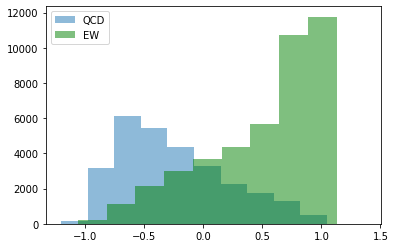

In [1188]:
plt.hist(predictions_qcd,alpha=0.5, label='QCD')
plt.hist(predictions_ew,color='g', alpha=0.5,label='EW')
plt.legend()

In [1189]:
predictions = mod.predict(X_test)
len(predictions)

71025

In [342]:
import matplotlib.pyplot as plt

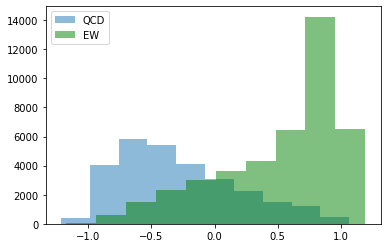

In [1103]:
plt.hist(predictions_qcd,alpha=0.5, label='QCD')
plt.hist(predictions_ew,color='g', alpha=0.5,label='EW')
plt.legend()

In [265]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import numpy

In [1190]:
cutoff = 0.0
cat_predict = [1 if x > cutoff else -1 for x in predictions] 
print("Roc score is", roc_auc_score(cat_predict, y_test))

Roc score is 0.7720323756455267


In [1191]:
tn, fp, fn, tp = confusion_matrix(cat_predict, y_test).ravel()
print(confusion_matrix(cat_predict, y_test))
tot_qcd = len(predictions_qcd)
print("\nTotal QCD", tot_qcd)
print("-------------------------------")
print("QCD as QCD", tn, "(%0.02f percent)" % (tn/tot_qcd*100))
print("QCD as EW", fp, "(%0.02f percent)" % (fp/tot_qcd*100))

tot_ew = len(predictions_ew)
print("\nTotal EW", tot_ew)
print("-------------------------------")
print("EW as QCD", fn, "(%0.02f percent)" % (fn/tot_ew*100))
print("EW as EW", tp, "(%0.02f percent)" % (tp/tot_ew*100))
print("-------------------------------")
print("Overall accuracy", accuracy_score(cat_predict, y_test))

[[20574  7805]
 [ 7715 34931]]

Total QCD 28289
-------------------------------
QCD as QCD 20574 (72.73 percent)
QCD as EW 7805 (27.59 percent)

Total EW 42736
-------------------------------
EW as QCD 7715 (18.05 percent)
EW as EW 34931 (81.74 percent)
-------------------------------
Overall accuracy 0.7814853924674411


In [1192]:
cutoff = 0.5
print("Rate of acceptance")
acc_rate_sig = len([x for x in filter(lambda x: x > cutoff, predictions_ew)])/(eventsProcessed(ewwz_file)*testsize)
acc_rate_bkgd = len([x for x in filter(lambda x: x > cutoff, predictions_qcd)])/(eventsProcessed(qcdwz_file)*testsize)
#acc_bkgd = testqcd_emm_wtruth[testqcd_emm_wtruth["prediction"] > 0.9]
print("Signal", acc_rate_sig)
print("Background", acc_rate_bkgd)

Rate of acceptance
Signal 0.0521
Background 0.0002472334245826734


In [1193]:
print("Scaled by cross section and 36 fb-1")
print("Signal", acc_rate_sig*17.5*36)
print("Background", acc_rate_bkgd*4.43*1000*36)

Scaled by cross section and 36 fb-1
Signal 32.823
Background 39.428786552444755


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


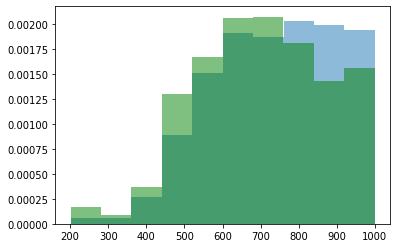

In [1174]:
X_test_ew["predict"] = predictions_ew
X_test_qcd["predict"] = predictions_qcd
ewklike = X_test_ew[(X_test_ew["predict"] > 0.5) & (X_test_ew["mjj"] < 1000)]
ewklike_qcd = X_test_qcd[(X_test_qcd["predict"] > 0.5) & (X_test_qcd["mjj"] < 1000)]
plt.hist(ewklike["mjj"],alpha=0.5, label='EW', normed=True)
plt.hist(ewklike_qcd["mjj"],color='g', alpha=0.5,label='EW', normed=True)
plt.show()

In [516]:
import numpy as np

In [1196]:
ewhist, bins = np.histogram(predictions_ew, bins=[0, 0.5, 0.6, 0.7, 0.8, 0.9, 2])
qcdhist, bins = np.histogram(predictions_qcd, bins=[0, 0.5, 0.6, 0.7, 0.8, 0.9, 2])
ewhist = ewhist*17.6*36/(eventsProcessed(ewwz_file)/2)
qcdhist = qcdhist*4430*36/(eventsProcessed(qcdwz_file)/2)
print(ewhist)
print(qcdhist)
print(17.6*36/eventsProcessed(ewwz_file))
print(4430*36/eventsProcessed(qcdwz_file))

[11.2540032  3.1084416  3.8041344  5.0675328  7.4460672 13.584384 ]
[85.08741822 11.26536759  9.61913909  8.84444332  6.53649552  3.16334104]
0.0006336
0.008069747554736955


6
7


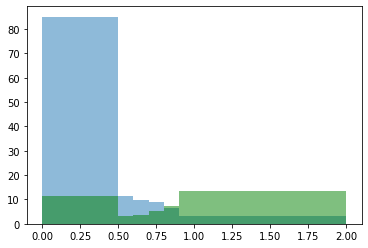

In [1197]:
plt.hist(bins[:-1], weights=qcdhist, bins=bins, alpha=0.5)
plt.hist(bins[:-1], weights=ewhist, bins=bins,color='g', alpha=0.5)
print(len(ewhist))
print(len(bins))

In [1198]:
ew_processed = eventsProcessed(ewwz_file)
qcd_processed = eventsProcessed(qcdwz_file)
print(len(ew_df))
print(len(ew_df[(ew_df.mjj > 500) & (abs(ew_df.dEtajj) > 2.5)]))
print(len(ew_df[(ew_df.mjj > 500) & (abs(ew_df.dEtajj) > 2.5)])/ew_processed*17.6*36)

print("\n", len(qcd_df))
print(len(qcd_df[(qcd_df.mjj > 500) & (abs(qcd_df.dEtajj) > 2.5)]))
print(len(qcd_df[(qcd_df.mjj > 500) & (abs(qcd_df.dEtajj) > 2.5)])/qcd_processed*4300*36)

85567
54953
34.818220800000006

 56483
14271
111.78385544485317


In [602]:
qcd_processed

1000000.0

In [1097]:
import math
def approxLikelihood(sig_hist, bkgd_hist):
    term1 = 0
    term2 = 0
    for sig, bkgd in zip(sig_hist, bkgd_hist):
        term1 += (sig+bkgd)*math.log(1+sig/bkgd)
        term2 += sig
    return math.sqrt(2*(term1 - term2))

In [1199]:
print(approxLikelihood(ewhist, qcdhist))

6.4070129437731556


In [1106]:
ew_loose = ew_df[(ew_df.mjj > 500) & (abs(ew_df.dEtajj) > 2.5)]
qcd_loose = qcd_df[(qcd_df.mjj > 500) & (abs(qcd_df.dEtajj) > 2.5)]
ew_mjj_hist,bins = numpy.histogram(ew_loose["mjj"], bins=[500,750,1000, 1250, 1500, 2000, 10000])
qcd_mjj_hist,bins = numpy.histogram(qcd_loose["mjj"], bins=[500,750,1000, 1250, 1500, 2000, 10000])
ew_mjj_hist = ew_mjj_hist*17.6*36/eventsProcessed(ewwz_file)
qcd_mjj_hist = qcd_mjj_hist*4300*36/eventsProcessed(qcdwz_file)

(array([6.8751936, 6.266304 , 5.1410304, 4.0746816, 5.4540288, 7.0063488]),
 array([  500,   750,  1000,  1250,  1500,  2000, 10000]),
 <a list of 6 Patch objects>)

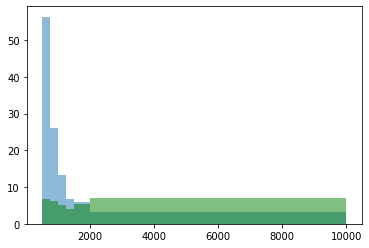

In [1107]:
plt.hist(bins[:-1], weights=qcd_mjj_hist, bins=bins, alpha=0.5)
plt.hist(bins[:-1], weights=ew_mjj_hist, bins=bins, alpha=0.5, color='g')

In [1108]:
print(approxLikelihood(ew_mjj_hist, qcd_mjj_hist))
len(ew_mjj_hist)

4.438671382301406


6

In [1200]:
print(approxLikelihood(ewhist, qcdhist)/approxLikelihood(ew_mjj_hist, qcd_mjj_hist))

1.4434528695501636


In [787]:
print("Processed QCD", qcd_processed)
print("Accepted loose QCD", len(qcd_loose))

Processed QCD 19762700.0
Accepted loose QCD 14271


In [1113]:
ew_bdt = X_test_ew[(X_test_ew.mjj > 500) & (abs(X_test_ew.dEtajj) > 2.5)]
ew_bdt = X_test_qcd[(X_test_qcd.mjj > 500) & (abs(X_test_qcd.dEtajj) > 2.5)]
ew_bdtTight_hist,bins = numpy.histogram(X_test_ew["predict"])
qcd_bdtTight_hist,bins = numpy.histogram(X_test_qcd["predict"])
#ew_bdtTight_hist = ew_bdtTight_hist*17.6*36/(eventsProcessed(ewwz_file)*testsize)
#qcd_bdtTight_hist = qcd_bdtTight_hist*4300*36/(eventsProcessed(qcdwz_file)*testsize)

(array([ 377., 4037., 5848., 5419., 4131., 3050., 2252., 1518., 1213.,
         444.]),
 array([-1.2172543 , -0.98875153, -0.7602488 , -0.53174603, -0.30324328,
        -0.07474053,  0.15376222,  0.38226497,  0.6107677 ,  0.8392705 ,
         1.0677732 ], dtype=float32),
 <a list of 10 Patch objects>)

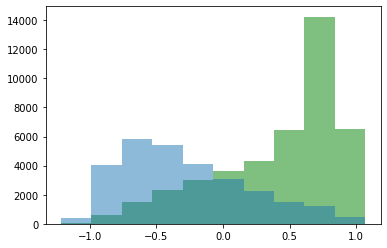

In [1114]:
plt.hist(bins[:-1], weights=ew_bdtTight_hist, bins=bins, alpha=0.5, color='g', label='EW')
plt.hist(bins[:-1], weights=qcd_bdtTight_hist, bins=bins, alpha=0.5, label='QCD')

In [1118]:
bins=[0,250,500,1000,1250,1500,3000]
ew_mjj_bdtTight_hist,bins = numpy.histogram(X_test_ew[X_test_ew.predict > 0.5]["mjj"], bins=bins)
qcd_mjj_bdtTight_hist,bins = numpy.histogram(X_test_qcd[X_test_qcd.predict > 0.5]["mjj"], bins=bins)
ew_mjj_bdtTight_hist = ew_mjj_bdtTight_hist*17.6*36/(eventsProcessed(ewwz_file)*testsize)
qcd_mjj_bdtTight_hist = qcd_mjj_bdtTight_hist*4300*36/(eventsProcessed(qcdwz_file)*testsize)

(array([ 0.125327  ,  3.46215851, 19.09670237,  5.51438822,  3.02351399,
         4.84075556]),
 array([   0,  250,  500, 1000, 1250, 1500, 3000]),
 <a list of 6 Patch objects>)

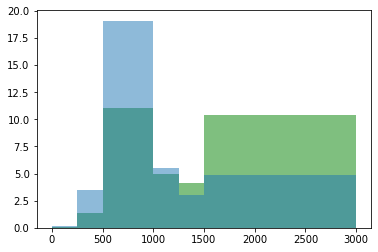

In [1119]:
plt.hist(bins[:-1], weights=ew_mjj_bdtTight_hist, bins=bins, alpha=0.5, color='g', label='EW')
plt.hist(bins[:-1], weights=qcd_mjj_bdtTight_hist, bins=bins, alpha=0.5, label='QCD')

In [1120]:
bins=[0,1,2,3,4,5,6]
ew_etajj_bdtTight_hist,bins = numpy.histogram(abs(X_test_ew[X_test_ew.predict > 0.5]["dEtajj"]), bins=bins)
qcd_etajj_bdtTight_hist,bins = numpy.histogram(abs(X_test_qcd[X_test_qcd.predict > 0.5]["dEtajj"]), bins=bins)
ew_etajj_bdtTight_hist = ew_etajj_bdtTight_hist*17.6*36/(eventsProcessed(ewwz_file)*testsize)
qcd_etajj_bdtTight_hist = qcd_etajj_bdtTight_hist*4300*36/(eventsProcessed(qcdwz_file)*testsize)

(array([1.09661129, 3.55615376, 7.75460843, 9.57185   , 7.89560131,
        4.21412054]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

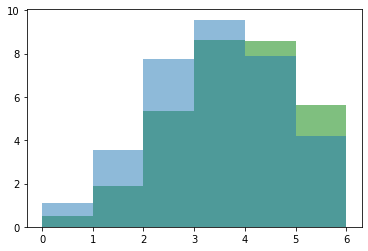

In [1121]:
plt.hist(bins[:-1], weights=ew_etajj_bdtTight_hist, bins=bins, alpha=0.5, color='g', label='EW')
plt.hist(bins[:-1], weights=qcd_etajj_bdtTight_hist, bins=bins, alpha=0.5, label='QCD')